### Introduction

The data mining task for this model comparison is to classify data based on the category it was originally extracted from Google.



In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import string
import re
from nltk.stem import PorterStemmer
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display
from matplotlib import rcParams

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (16,9)

In [3]:
data = pd.read_json("noticias_vzla_combined.json")
data['category_id'] = data['category'].factorize(sort=True)[0]

In [4]:
data.sample(20)

,fecha,strategy,texto,title,url,category,texto_tokenized,texto_nonstop,texto_stemmed,texto_punct,sentiment,texto_lemmatized,category_id
833,None,2,Por Alexander C. Hammond\n¿Cuál fue el resulta...,Venezuela nos recuerda que el derecho de propi...,http://www.laprensa.com.ar/473291-Venezuela-no...,economia,"[por, alexander, c, hammond, cuál, fue, el, re...","[alexander, c, hammond, cuál, resultado, exper...","[alexand, c, hammond, cuál, resultado, experim...",Por Alexander C Hammond\n¿Cuál fue el resultad...,-0.2960,"[alexander, c, hammond, cuál, resultado, exper...",0
470,10/08/2018,2,La investigación venezolana sobre el caso dio ...,"Brasil condena ""represión"" en Venezuela tras d...",http://www.eluniversal.com/politica/17458/bras...,represion,"[la, investigación, venezolana, sobre, el, cas...","[investigación, venezolana, caso, dio, giro, v...","[investigación, venezolana, caso, dio, giro, v...",La investigación venezolana sobre el caso dio ...,0.0000,"[investigación, venezolana, caso, dio, giro, v...",2
183,19/12/2018,2,Miembro de GDA. Grupo de Diarios América\nProt...,"Susana Raffalli: ""El 63% de los migrantes vene...",https://www.lanacion.com.ar/2203780-susana-raf...,hambre,"[miembro, de, gda, grupo, de, diarios, américa...","[miembro, gda, grupo, diarios, américa, proteg...","[miembro, gda, grupo, diario, américa, protegi...",Miembro de GDA Grupo de Diarios América\nProte...,0.0516,"[miembro, gda, grupo, diarios, américa, proteg...",1
228,2018-10-22 08:56,1,El dos veces candidato a la Presidencia de Ven...,"Capriles: Maduro hace ""negocio multimillonario...",https://www.elnuevodiario.com.ni/internacional...,hambre,"[el, dos, veces, candidato, a, la, presidencia...","[dos, veces, candidato, presidencia, henrique,...","[do, vece, candidato, presidencia, henriqu, ca...",El dos veces candidato a la Presidencia de Ven...,-0.8591,"[do, veces, candidato, presidencia, henrique, ...",1
653,2019-02-09T07:24:22+00:00,1,PanAm Post - La principal fuente de noticias y...,Reconstruir la economía venezolana es analizar...,https://es.panampost.com/guillermo-rodriguez/2...,economia,"[panam, post, la, principal, fuente, de, notic...","[panam, post, principal, fuente, noticias, aná...","[panam, post, princip, fuent, noticia, análisi...",PanAm Post La principal fuente de noticias y ...,-0.9808,"[panam, post, principal, fuente, noticias, aná...",0
628,2019-02-15T00:12:49+00:00,1,sas.cmd.push(function() {\n sas.render(...,ECONOMÍA Y POLÍTICA: Venezuela: frenazo ruso a...,https://almomento.mx/economia-y-politica-venez...,economia,"[sas, cmd, push, function, sas, render, 7846, ...","[sas, cmd, push, function, sas, render, 7846, ...","[sa, cmd, push, function, sa, render, 7846, fo...",sascmdpushfunction \n sasrender Forma...,0.0000,"[sa, cmd, push, function, sa, render, 7846, fo...",0
64,None,2,Chihuahua.- Derivada de la crisis humanitaria ...,Cambian bolívares por pesos a beneficio de niñ...,http://laopcion.com.mx/noticia/228838,hambre,"[chihuahua, derivada, de, la, crisis, humanita...","[chihuahua, derivada, crisis, humanitaria, pre...","[chihuahua, derivada, crisi, humanitaria, prev...",Chihuahua Derivada de la crisis humanitaria qu...,-0.6249,"[chihuahua, derivada, crisis, humanitaria, pre...",1
546,2019-02-51T07:55:01-0400,1,La IE Business School consultó a 106 empresas ...,Inestabilidad de Venezuela ahuyenta la inversi...,http://www.el-nacional.com/noticias/economia/i...,economia,"[la, ie, business, school, consultó, a, 106, e...","[ie, business, school, consultó, 106, empresas...","[ie, busi, school, consultó, 106, empresa, esp...",La IE Business School consultó a empresas de ...,-0.9671,"[ie, business, school, consultó, 106, empresas...",0
38,2019-02-12T15:58:17-03:00,1,Opositores marcharon este martes en varias ciu...,Publinews Guatemala,https://www.publinews.gt/gt/noticias/2019/02/1...,hambre,"[opositores, marcharon, este, martes, en, vari...","[opositores, marcharon, martes, varias, ciudad...","[opositor, marcharon, mart, varia, ciuda

Balanceo de clases a predecir

Hay entre 250 a 350 documentos por clase

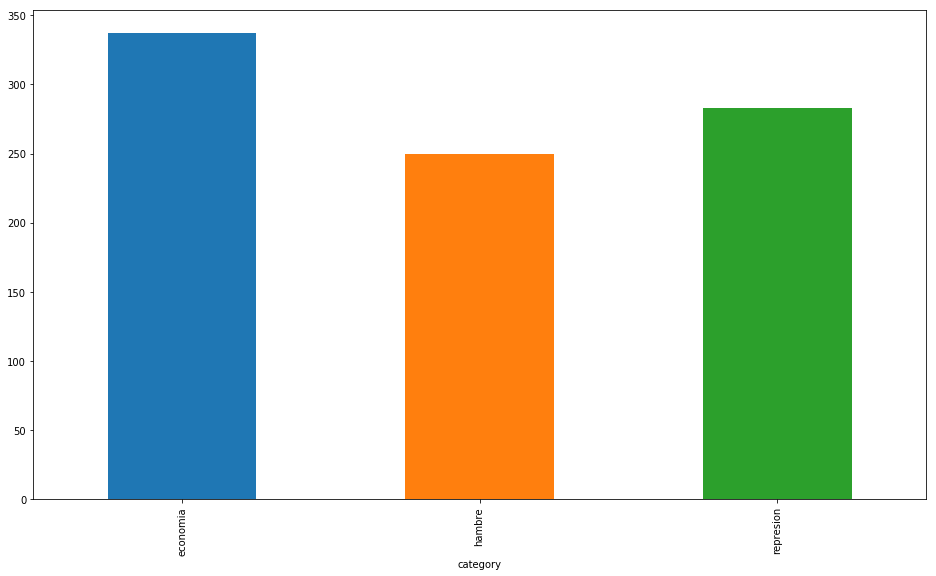

In [5]:
data.groupby('category').sentiment.count().plot.bar(ylim=0)

Algunos mappings útiles para mostrar gráficos con títulos relevantes

In [6]:
category_id_df = data[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

Algunas stopwords utilizadas en TF-IDF vectorizer

In [7]:
stopwords = ["venezuela", 
             "maduro",
             "economía",
             "economia",
             "represión","hambre","nicolás","juan", "guaidó",""] + nltk.corpus.stopwords.words("spanish")

Se añadió nltk y stemmer, para ver si se podía optimizar la separación de los grupos utilizando PCA, pero no se obtuvo resultados satisfactorios

In [8]:
#Función para obtener el texto sin signos de puntiación, tokenizado, con stemming y sin stopwords
ps = PorterStemmer()
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopwords]  # remove stopwords and stemming
    return text
data["cleaned_text"] = data["texto"].apply(lambda x: " ".join(clean_text(x)))

Aquí se muestran que hay 870 documentos y 10754 features (unigrams y bigrams)

In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords)

features = tfidf.fit_transform(data["cleaned_text"]).toarray()
labels = data.category_id
features.shape

(870, 10754)

In [10]:
from sklearn.feature_selection import chi2

N = 3
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Palabras más correlacionadas:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Bigramas más correlacionados:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'economia':
  . Palabras más correlacionadas:
       . barril
       . pdvsa
       . petróleo
  . Bigramas más correlacionados:
       . fondo monetario
       . monetario internacion
       . banco central
# 'hambre':
  . Palabras más correlacionadas:
       . alimentaria
       . fao
       . comida
  . Bigramas más correlacionados:
       . crisi alimentaria
       . alimentación agricultura
       . seguridad alimentaria
# 'represion':
  . Palabras más correlacionadas:
       . manifestacion
       . manifestant
       . protesta
  . Bigramas más correlacionados:
       . nacion bolivariana
       . cuerpo seguridad
       . guardia nacion


### Separación de clases

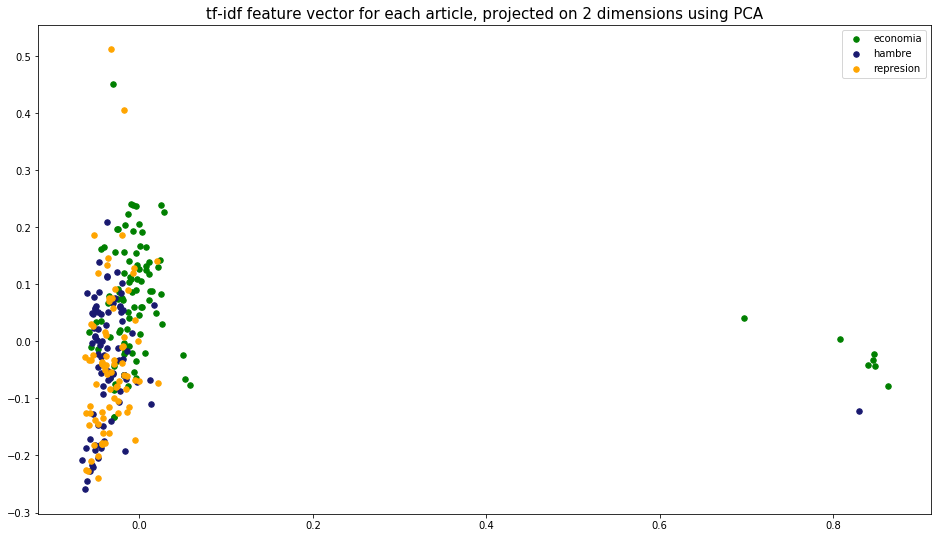

In [11]:
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(30)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = PCA(n_components=2, random_state=3000).fit_transform(features[indices])
colors = ['green', 'midnightblue', 'orange']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions using PCA",
          fontdict=dict(fontsize=15))
plt.legend()

En este gráfico apreciamos que al proyectar el vector de cada documento coloreado por su categoría, PCA genera puntos que no están separados en 2 dimensiones, sin embargo, si observamos los datos parecen estar superpuestos en las primeras dos componentes principales, por lo que es posible una separación.

### Comparación de modelos

Vamos a comparar varios modelos, utilizando las funcionalidades que tiene sklearn.

Nótese que estamos comparando modelos utilizando 5-fold cross validation.

LinearSVC: Escogí este modelo ya que se adapta bastante bien a los outliers, y no tiene problemas con altas dimensionalidades.

MultinomialNB: Naive Bayes como línea de accuracy mínima.

LogisticRegression: Ya que TF-IDF está normalizado con L2 normalization, los valores son probabilidades, adecuados para regresión logística.

RandomForest: Darle una oportunidad a un Ensemble.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    LinearSVC()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Aquí tomaremos los resultados acumulados del cross validation para graficar box plots

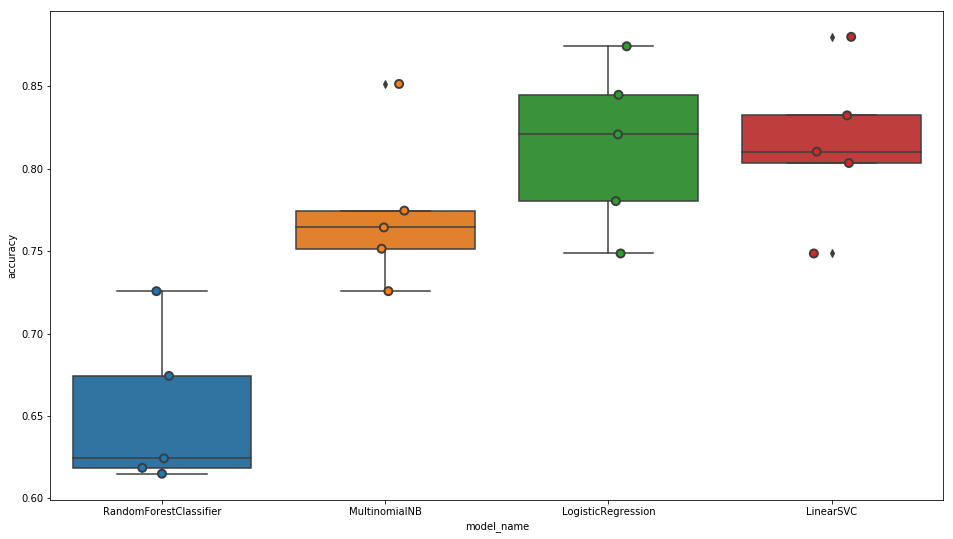

In [13]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

Aquí tomamos la mediana de los resultados del 5-fold crossvalidation

Aquí tomamos la mediana de los resultados del 5-fold crossvalidation

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.814951
LogisticRegression        0.813768
MultinomialNB             0.773504
RandomForestClassifier    0.651543
Name: accuracy, dtype: float64

Here we test CV scores across the two principal contenders, comparing across different hyperparameters for the models with most accuracy. Logistic Regression and Linear Support Vector Classifier

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    LogisticRegression(random_state=0, C = 1.5),
    LogisticRegression(random_state=0, C = 1.0),
    LogisticRegression(random_state=0, C = 0.5),
    LinearSVC(C = 1.5),
    LinearSVC(C = 1.0),
    LinearSVC(C = 0.5)
]
CV = 5
cv_df_hyperparams = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__ + " C = {}".format(model.get_params()["C"])
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df_hyperparams = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [16]:
cv_df_hyperparams.groupby('model_name').accuracy.mean()

model_name
LinearSVC C = 0.5             0.813768
LinearSVC C = 1.0             0.814951
LinearSVC C = 1.5             0.810360
LogisticRegression C = 0.5    0.789577
LogisticRegression C = 1.0    0.813768
LogisticRegression C = 1.5    0.812619
Name: accuracy, dtype: float64

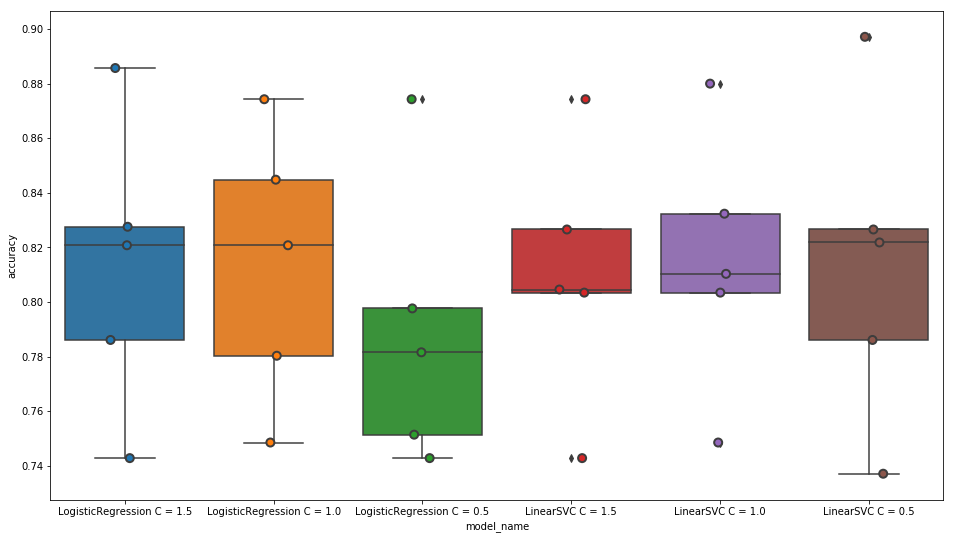

In [17]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df_hyperparams)
sns.stripplot(x='model_name', y='accuracy', data=cv_df_hyperparams, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

Se puede observar que regresión logística logra un accuracy del 81%, junto con SVM lineal.

In [18]:
model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [19]:
len(model.coef_[0])

10754

Aquí vamos a graficar una matriz de confusión, para entender cómo se equivocó LogisticRegression

Text(0.5,60,'Predicted')

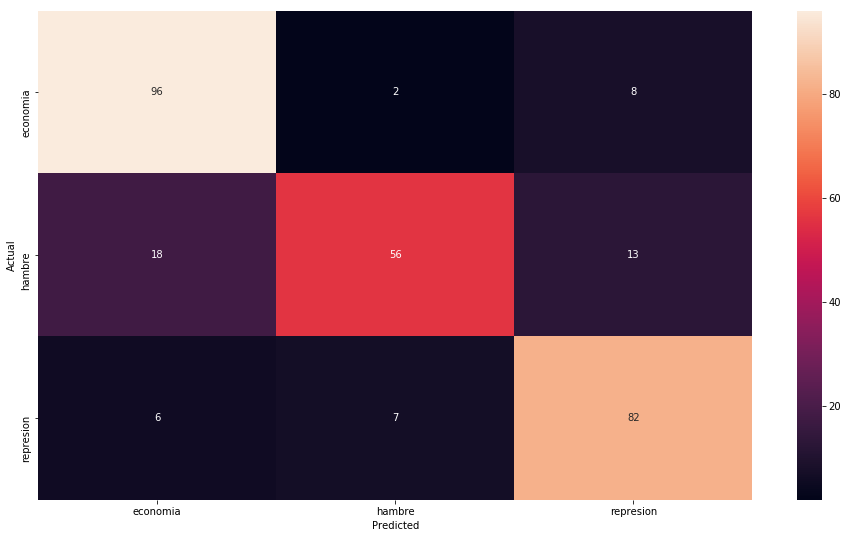

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Este pequeño código hace sencillo ver las noticias mal clasificadas

In [21]:
lista_misclassified = []
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            string_mispred = "'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted])
            print(string_mispred)
            mispredicted = data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]
            lista_misclassified.append({"actual": id_to_category[actual],"predicted": id_to_category[predicted], "points": mispredicted})
            display(mispredicted[['title', 'texto','url']])
            print('')

'hambre' predicted as 'economia' : 18 examples.


,title,texto,url
64,Cambian bolívares por pesos a beneficio de niñ...,Chihuahua.- Derivada de la crisis humanitaria ...,http://laopcion.com.mx/noticia/228838
97,"Nicolás Maduro en lujoso restaurante, mientras...","El presidente de Venezuela, Nicolás Maduro, fu...",https://www.excelsior.com.mx/global/nicolas-ma...
69,Venezuela tiene hambre,Venezuela tiene hambre; aparte de las ansiedad...,https://cadenaser.com/programa/2019/01/24/hora...
35,Jacobo Torres de León: En Venezuela no nos est...,ND / 19 feb 2019.- El representante de la Cent...,http://www.noticierodigital.com/2019/02/jacobo...
152,Hasta la FAO deja en ridículo a Errejón,,https://www.libremercado.com/2018-11-13/hasta-...
92,La Venezuela profunda recurre a la siembra par...,,https://www.abc.es/internacional/abci-venezuel...
186,"Venezuela, cuando el hambre y la pobreza se co...",Un vendedor espera en la oscuridad dentro de u...,https://www.elespanol.com/mundo/america/201712...
134,Ganar con el hambre en Venezuela,Una empresa fantasma con sede en Sabadell (Bar...,https://elpais.com/politica/2018/03/17/actuali...
60,Niño venezolano relata la difícil situación en...,,https://noticias.canalrcn.com/nacional-regione...
49,"Venezuela 2019, la refundación de la nación",La opinión de\n Froilán Barrios...,http://www.el-nacional.com/noticias/columnista...



'represion' predicted as 'economia' : 6 examples.


,title,texto,url
306,Crisis en Venezuela: por qué la incertidumbre ...,Comparte esta actualización en\nEstos son vínc...,https://www.bbc.com/mundo/noticias-america-lat...
324,Estados Unidos sanciona a funcionarios de la c...,La batería de sanciones de Estados Unidos cont...,https://elpais.com/internacional/2019/02/15/ac...
349,Corto documental Nunca Jamás en Venezuela: Her...,,https://www.infobae.com/america/venezuela/b0dd...
299,La represión de las protestas se ha segmentado...,Grupo La Provincia cumple quince años con una ...,https://www.grupolaprovincia.com/internacional...
363,"Nicolás Maduro: ""Jamás ha habido ni habrá repr...",Comparte esta actualización en\nEstos son vínc...,https://www.bbc.com/mundo/noticias-47215367
316,Puntallana condena “la represión” del régimen ...,Twitter\n \n \n Facebook\...,https://www.eldiario.es/canariasahora/lapalmaa...



'economia' predicted as 'hambre' : 2 examples.


,title,texto,url
624,La eterna adolescencia de sobrevivir en Venezuela,Casi como aprender a manejarse de cero cada ma...,https://gestion.pe/economia/eterna-adolescenci...
541,Venezuela cierra frontera clave por mar y aire...,(CNN) — Venezuela cerró una frontera marítima ...,https://cnnespanol.cnn.com/2019/02/20/venezuel...



'represion' predicted as 'hambre' : 7 examples.


,title,texto,url
466,Saqueos y represión en Zulia,Diario Ámbito Financiero\nTel: 4349-1500 - Pas...,https://www.ambito.com/saqueos-y-represion-zul...
343,«Entraron en mi casa con armas. Me fui de Vene...,"Este sitio web puede utilizar algunas ""cookies...",https://www.diaridetarragona.com/tarragona/Ent...
279,Crisis en Venezuela: tras una jornada de prote...,Miembro de GDA. Grupo de Diarios América\nProt...,https://www.lanacion.com.ar/2213895-crisis-ven...
519,"Venezuela: cuatro muertos, represión y una est...",Miembro de GDA. Grupo de Diarios América\nProt...,https://www.lanacion.com.ar/2213520-venezuela-...
424,"Maduro sobrevive, Venezuela agoniza","Consulta la portada de EL PAÍS, Edición Améric...",https://elpais.com/internacional/2018/07/28/ac...
379,"Colette Capriles, filósofa venezolana: Chavism...",La filósofa venezolana Colette Capriles es pro...,https://www.laprensa.com.ni/2019/02/18/politic...
384,Luis Ortiz: Maduro dirige una narcotiranía con...,JMF: ¿Cómo está ahora Venezuela?\nLuis Ortiz: ...,https://intereconomia.com/tendencias/luis-orti...



'economia' predicted as 'represion' : 8 examples.


,title,texto,url
650,Los obispos apoyan la postura de Francisco sob...,"Estimado lector, muchas gracias por su interés...",https://www.eldia.com/nota/2019-2-5-3-1-31-los...
651,Pedro Sánchez reconoce a Guaidó como president...,"El presidente del Gobierno, Pedro Sánchez, ha ...",https://cincodias.elpais.com/cincodias/2019/02...
813,Cómo Venezuela ha llegado hasta aquí (III: el ...,¿Es moralmente lícito matar al tirano?\nEsta p...,https://infovaticana.com/blogs/teologia-econom...
824,"Muro fronterizo, inmigración, economía y crisi...",Univision6 Feb 2019 – 11:40 PM EST,https://www.univision.com/shows/noticiero-univ...
661,Reactivar la negociación: necesidad de una Nic...,<!--\r\n\t\t\t dows = new A...,https://elmundo.sv/reactivar-la-negociacion-ne...
844,Juan Guaidó presentó el 'Plan País' que reacti...,"""Tengo cáncer terminal en etapa 4 y no hay for...",https://www.am.com.mx/2019/02/01/mundo/juan-gu...
632,Guerra sostiene que EEUU evitó injerirse en la...,Si inicias sesión aceptas nuestra política de ...,https://www.publico.es/internacional/guerra-di...
563,AméricaEconomía.com,Caracas. Durante un acto de graduación de médi...,https://www.americaeconomia.com/politica-socie...



'hambre' predicted as 'represion' : 13 examples.


,title,texto,url
38,Publinews Guatemala,Opositores marcharon este martes en varias ciu...,https://www.publinews.gt/gt/noticias/2019/02/1...
70,ARZOBISPO DE VENEZUELA: EL PUEBLO TIENE HAMBRE...,Mons. José Luis Azuaje / Crédito: Conferencia ...,http://vida-nueva.com/arzobispo-venezuela-pueb...
20,Amnistía Internacional acusó al régimen de Mad...,Amnistía Internacional (AI) responsabilizó est...,https://www.infobae.com/america/venezuela/2019...
19,Informe de Amnistía Internacional: en Venezuel...,"“Venezuela: Hambre, castigo y miedo, la fórmul...",https://www.cambio16.com/informe-de-amnistia-i...
37,Radio Agricultura,Opositores marchaban este martes en varias ciu...,https://www.radioagricultura.cl/internacional/...
244,La contundente carta de Mons. Mario Moronta a ...,La iglesia en Venezuela también se ha visto af...,http://www.venezuelaaldia.com/2019/02/18/la-co...
44,Arzobispo de Venezuela: El pueblo tiene hambre...,El Presidente de la Conferencia Episcopal de V...,https://www.aciprensa.com/noticias/arzobispo-d...
139,"Juan Guaidó, presidente de la Asamblea Naciona...","“¡Eres un usurpador! Nicolás, el 10 este Parla...",https://www.latercera.com/mundo/noticia/jaime-...
61,Periodista alemán preso en Venezuela por fotog...,"Redacción de CiberCuba Mié, 06/02/2019 - 9:10p...",https://www.cibercuba.com/noticias/2019-02-06-...
249,Periodista alemán detenido en Venezuela desde ...,*Esta nota ha sido actualizada a las 7:21P.M. ...,https://knightcenter.utexas.edu/es/blog/00-205...


Como se puede observar, en estos ejemplos pareciera que una clasificación multinomial (cada noticia pertenece a una sola categoría.) es poco acertada, por lo que dejamos al lector para que decida.

In [22]:
# Sacar unos ejemplos para el Paper
print(lista_misclassified[-1])
print(lista_misclassified[-1]["points"])
lista_misclassified[-1]["points"]["url"][306]


{'actual': 'hambre', 'predicted': 'represion', 'points':                          fecha  strategy  \
38   2019-02-12T15:58:17-03:00         1   
70                        None         2   
20                        None         2   
19                  11/12/2018         2   
37                        None         2   
244  2019-02-18T12:54:56+00:00         1   
44                        None         2   
139                       None         2   
61                  06/02/2019         2   
249                 06/02/2019         2   
145  2018-12-16T17:55:09+00:00         1   
21            2019-02-10T14:08         1   
85                  18/02/2019         2   

                                                 texto  \
38   Opositores marcharon este martes en varias ciu...   
70   Mons. José Luis Azuaje / Crédito: Conferencia ...   
20   Amnistía Internacional (AI) responsabilizó est...   
19   “Venezuela: Hambre, castigo y miedo, la fórmul...   
37   Opositores marchaban este marte

KeyError: 306

## Validation set

I asked a partner to borrow me his dataset as a validation test and so this is unexposed data to the classifier. 

It isn't in the right format, but close enough that we can use it anyways.

In [23]:
validation_set = pd.read_json("validation_filtered.json")

In [24]:
validation_set['category_id'] = validation_set['category'].factorize(sort=True)[0]

In [25]:
validation_set.head()

,Title,Date,Parrafo,Link,Topic,texto_tokenized,texto_nonstop,texto_stemmed,texto_punct,sentiment,texto_lemmatized,category,category_id
0,Éxodo de venezolanos sin precedentes marcó el ...,31 dic. 2018,El éxodo venezolano es considerado por la ONU ...,http://www.eluniverso.com/2018/12/31/video/711...,Economia,"[el, éxodo, venezolano, es, considerado, por, ...","[éxodo, venezolano, considerado, onu, mayor, m...","[éxodo, venezolano, considerado, onu, mayor, m...",El éxodo venezolano es considerado por la ONU ...,-0.6249,"[éxodo, venezolano, considerado, onu, mayor, m...",economia,0
1,La crisis se desbordó en Venezuela en 2018,29 dic. 2018,"Ahogado por una crisis económica, Venezuela te...",https://www.eluniverso.com/noticias/2018/12/29...,Economia,"[ahogado, por, una, crisis, económica, venezue...","[ahogado, crisis, económica, termina, año, paí...","[ahogado, crisi, económica, termina, año, país...",Ahogado por una crisis económica Venezuela ter...,-0.3818,"[ahogado, crisis, económica, termina, año, paí...",economia,0
10,Militares rusos e iraníes en Venezuela tensan ...,13 dic. 2018,América debe estar ‘alerta’ frente a los ejerc...,https://www.eluniverso.com/noticias/2018/12/13...,Economia,"[américa, debe, estar, alerta, frente, a, los,...","[américa, debe, alerta, frente, ejercicios, de...","[américa, debe, alerta, frent, ejercicio, defe...",América debe estar ‘alerta’ frente a los ejerc...,-0.5423,"[américa, debe, alerta, frente, ejercicios, de...",economia,0
100,Ecuador abandona la ALBA y muestra ‘frustració...,23 ago. 2018,El gobierno ecuatoriano anunció este jueves qu...,https://www.eluniverso.com/noticias/2018/08/23...,Economia,"[el, gobierno, ecuatoriano, anunció, este, jue...","[gobierno, ecuatoriano, anunció, jueves, deja,...","[gobierno, ecuatoriano, anunció, juev, deja, g...",El gobierno ecuatoriano anunció este jueves qu...,0.3400,"[gobierno, ecuatoriano, anunció, jueves, deja,...",economia,0
101,Ecuador implementa 'corredor humanitario' para...,23 ago. 2018,El Gobierno de Ecuador mantiene la exigencia d...,https://www.eluniverso.com/noticias/2018/08/23...,Economia,"[el, gobierno, de, ecuador, mantiene, la, exig...","[gobierno, ecuador, mantiene, exigencia, prese...","[gobierno, ecuador, mantien, exigencia, presen...",El Gobierno de Ecuador mantiene la exigencia d...,-0.7650,"[gobierno, ecuador, mantiene, exigencia, prese...",economia,0


In [26]:
#Función para obtener el texto sin signos de puntiación, tokenizado, con stemming y sin stopwords
ps = PorterStemmer()
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopwords]  # remove stopwords and stemming
    return text
validation_set["cleaned_text"] = validation_set["Parrafo"].apply(lambda x: " ".join(clean_text(x)))

In [27]:
text_features = tfidf.transform(validation_set["cleaned_text"])
predictions = model.predict(text_features)


Text(0.5,60,'Predicted')

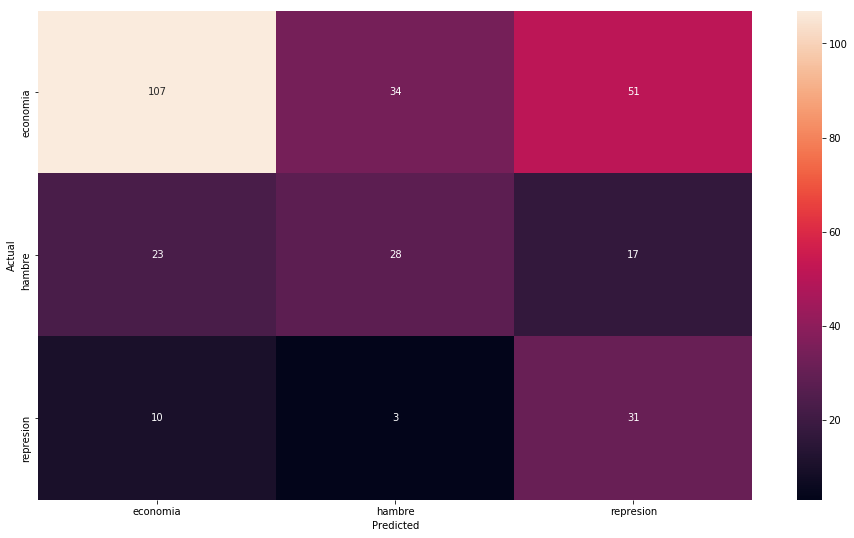

In [38]:
conf_mat_test = confusion_matrix(validation_set.category_id, predictions)
sns.heatmap(conf_mat_test, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [47]:
conf_mat_test

array([[107,  34,  51],
       [ 23,  28,  17],
       [ 10,   3,  31]])

In [34]:
category_id_df_test = validation_set[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id_test = dict(category_id_df_test.values)
id_to_category_test = dict(category_id_df_test[['category_id', 'category']].values)

In [45]:
from sklearn.metrics import classification_report

print(classification_report(validation_set.category_id, predictions,target_names=category_to_id_test))

             precision    recall  f1-score   support

   economia       0.76      0.56      0.64       192
     hambre       0.43      0.41      0.42        68
  represion       0.31      0.70      0.43        44

avg / total       0.62      0.55      0.56       304



Parece que el clasificador tiene problemas para generalizar sobre el dataset de prueba, sin embargo hay que notar que el vocabulario es muchísimo más reducido. 

Es probable que este problema se haya dado por filtrado insuficiente en los datos de prueba. 

En un futuro trabajo se podría intentar filtrar de manera más exhaustiva el texto minado

In [39]:
for predicted in category_id_df_test.category_id:
    for actual in category_id_df_test.category_id:
        if predicted != actual and conf_mat_test[actual, predicted] >= 2:
            string_mispred = "'{}' predicted as '{}' : {} examples.".format(id_to_category_test[actual], id_to_category_test[predicted], conf_mat_test[actual, predicted])
            print(string_mispred)
            # mispredicted = validation_set.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]
            mispredicted = validation_set.loc[(validation_set.category_id == actual) & (predictions == predicted)]
            display(mispredicted[['Title', 'Parrafo','Link']])
            print('')

'hambre' predicted as 'economia' : 23 examples.


,Title,Parrafo,Link
192,El presidente de Turquía ofrece ayuda a Nicolá...,El presidente turco Recep Tayyip Erdogan asegu...,https://www.eluniverso.com/noticias/2018/12/03...
193,Fin de la Guerra Fría,"Hoy, 3 de diciembre, se celebra el fin de la G...",https://www.eluniverso.com/opinion/2018/12/03/...
197,Presupuesto 2019: Senado argentino aprueba ley,"""No hay plata, no hay"", repite Roberto desde s...",https://www.eluniverso.com/noticias/2018/11/15...
206,"Presidente de Cuba ante la ONU: ""Somos la cont...",El presidente de Cuba Miguel Díaz-Canel se est...,https://www.eluniverso.com/noticias/2018/09/26...
211,¿Qué opina de la situación y migración de vene...,Debido a la recesión económica se han visto en...,https://www.eluniverso.com/opinion/2018/09/09/...
212,Migrar es crecer,Comencemos dejando en claro las siguientes pre...,https://www.eluniverso.com/opinion/2018/08/30/...
213,Jubilados protestan en Venezuela por pago de b...,Más de un millar de jubilados y pensionados pr...,https://www.eluniverso.com/noticias/2018/08/29...
215,Migración de Ecuador y países vecinos se pronu...,Estas son las principales novedades y proyecci...,https://www.eluniverso.com/noticias/2018/08/27...
216,"Crisis de Venezuela: ""El éxodo de los venezola...","En un día de julio, hasta 50.000 venezolanos c...",https://www.eluniverso.com/noticias/2018/08/24...
217,Venezolanos hacen fila por carne putrefacta,"Los residentes de Maracaibo, una ciudad conoci...",https://www.eluniverso.com/noticias/2018/08/24...



'represion' predicted as 'economia' : 10 examples.


,Title,Parrafo,Link
263,Triunfo de Hugo Chávez en 1998: cómo era la Ve...,"La suya era una revolución. Con él al frente, ...",https://www.eluniverso.com/noticias/2018/12/07...
274,"Lo bueno, lo malo, lo feo",Estos calificativos merecen las acciones de nu...,https://www.eluniverso.com/opinion/2018/08/29/...
281,Juan Manuel Santos: Veo cerca la caída del rég...,"El mandatario saliente de Colombia, Juan Manue...",https://www.eluniverso.com/noticias/nota/68839...
289,"Nicolás Maduro, desafiante ante rechazo mundia...",Un día después de la jornada de elecciones pre...,https://www.eluniverso.com/noticias/2018/05/22...
290,El Comecon del siglo XXI,Seis países de los doce que conforman la Unasu...,https://www.eluniverso.com/opinion/2018/04/27/...
291,"Miguel Díaz-Canel, el leal sucesor de los Cast...","Miguel Mario Díaz-Canel Bermúdez, el recordado...",https://www.eluniverso.com/noticias/2018/04/20...
293,"1,2 millones de venezolanos han emigrado en do...",La crisis en Venezuela sigue provocando que mi...,https://www.eluniverso.com/noticias/2018/02/14...
297,El Comecon del siglo XXI,Seis países de los doce que conforman la Unasu...,https://www.eluniverso.com/opinion/2018/04/27/...
298,"Miguel Díaz-Canel, el leal sucesor de los Cast...","Miguel Mario Díaz-Canel Bermúdez, el recordado...",https://www.eluniverso.com/noticias/2018/04/20...
300,"1,2 millones de venezolanos han emigrado en do...",La crisis en Venezuela sigue provocando que mi...,https://www.eluniverso.com/noticias/2018/02/14...



'economia' predicted as 'hambre' : 34 examples.


,Title,Parrafo,Link
0,Éxodo de venezolanos sin precedentes marcó el ...,El éxodo venezolano es considerado por la ONU ...,http://www.eluniverso.com/2018/12/31/video/711...
101,Ecuador implementa 'corredor humanitario' para...,El Gobierno de Ecuador mantiene la exigencia d...,https://www.eluniverso.com/noticias/2018/08/23...
119,Por qué Ecuador decidió exigir pasaporte a los...,La masiva diáspora venezolana preocupa cada ve...,https://www.eluniverso.com/noticias/2018/08/17...
122,"Ante la crisis, en Venezuela se dan limosnas c...","""No sepa tu izquierda lo que hace tu derecha"",...",https://www.eluniverso.com/noticias/2018/08/15...
135,Los zapatos rotos de un profesor venezolano co...,José Ibarra explotó de indignación al ver que ...,https://www.eluniverso.com/noticias/nota/68752...
145,Antonio Ledezma: Venezuela debe ser intervenida,Este político opositor al gobierno de Nicolás ...,https://www.eluniverso.com/noticias/2018/06/20...
154,Venezuela: elecciones iniciaron con escasa asi...,Con escasa asistencia de votantes a los centro...,https://www.eluniverso.com/noticias/2018/05/20...
155,Nicolás Maduro gana polémica reelección en Ven...,"El presidente de Venezuela, Nicolás Maduro, ga...",https://www.eluniverso.com/noticias/2018/05/20...
16,"En OEA, Colombia pide tomar conciencia sobre m...",Colombia pidió el miércoles a los estados miem...,https://www.eluniverso.com/noticias/2018/12/12...
164,La crisis venezolana presiona a los inmigrante...,"En la comuna El Arroyo, ubicada en la jurisdic...",https://www.eluniverso.com/noticias/2018/04/25...



'represion' predicted as 'hambre' : 3 examples.


,Title,Parrafo,Link
265,Demencial,Si creíamos que habíamos visto o leído todo ac...,https://www.eluniverso.com/opinion/2018/11/23/...
273,Miembro de la OEA pide declarar crisis de refu...,La OEA o la ONU deben declarar una crisis de r...,https://www.eluniverso.com/noticias/2018/09/10...
287,Antonio Ledezma: Venezuela debe ser intervenida,Este político opositor al gobierno de Nicolás ...,https://www.eluniverso.com/noticias/2018/06/20...



'economia' predicted as 'represion' : 51 examples.


,Title,Parrafo,Link
106,Hoy paro nacional en Venezuela en protesta por...,Estas son las principales novedades y proyecci...,https://www.eluniverso.com/noticias/2018/08/21...
108,OEA convoca a reunión para tratar crisis human...,La Organización de Estados Americanos (OEA) y ...,https://www.eluniverso.com/guayaquil/2018/08/2...
109,No se reportan víctimas ni daños de considerac...,"El gobernador del estado venezolano de Sucre, ...",https://www.eluniverso.com/noticias/2018/08/21...
110,Paro nacional en Venezuela en protesta por med...,IR ARRIBA© 2019 C.A. EL UNIVERSO. Todos los de...,http://www.eluniverso.com/2018/08/21/video/691...
111,"Sismo de magnitud 7,3 sacude el norte de Venez...","Un prolongado sismo, de magnitud 7,3 según el ...",https://www.eluniverso.com/noticias/2018/08/21...
112,Fuerte sismo en Venezuela,IR ARRIBA© 2019 C.A. EL UNIVERSO. Todos los de...,http://www.eluniverso.com/2018/08/21/video/691...
117,Huelga convocada en Venezuela por partidos de ...,La huelga convocada para el martes por tres de...,https://www.eluniverso.com/noticias/2018/08/19...
118,Tensión migratoria en Brasil por la situación ...,"El presidente brasileño, Michel Temer, convocó...",https://www.eluniverso.com/noticias/2018/08/19...
121,Tribunal Supremo de Venezuela en el exilio con...,El tribunal supremo de justicia venezolano par...,https://www.eluniverso.com/noticias/2018/08/15...
126,Gobierno venezolano va tras ‘autores’ de supue...,Un día después del supuesto atentado en contra...,https://www.eluniverso.com/noticias/2018/08/06...



'hambre' predicted as 'represion' : 17 examples.


,Title,Parrafo,Link
205,¡Salto a la otra orilla!,"Al comentar, en Radio Democracia, el discurso ...",https://www.eluniverso.com/opinion/2018/10/03/...
210,Gobierno de Donald Trump prefiere transición p...,El gobierno de Donald Trump dijo este domingo ...,https://www.eluniverso.com/noticias/2018/09/09...
218,OEA convoca a reunión para tratar crisis human...,La Organización de Estados Americanos (OEA) y ...,https://www.eluniverso.com/guayaquil/2018/08/2...
219,Huelga convocada en Venezuela por partidos de ...,La huelga convocada para el martes por tres de...,https://www.eluniverso.com/noticias/2018/08/19...
226,"No habrá perdón, dice Nicolás Maduro mientras ...","El presidente de Venezuela, Nicolás Maduro, se...",https://www.eluniverso.com/noticias/nota/68928...
227,Supuesto grupo rebelde se atribuye atentado co...,Un supuesto grupo rebelde que estaría integrad...,https://www.eluniverso.com/noticias/nota/68908...
234,Lanzan campaña por los presos en Venezuela,Unas 750 personas están encarceladas u obligad...,https://www.eluniverso.com/noticias/2018/06/08...
236,Dos generales entre detenidos en Venezuela por...,Dos generales encabezan un grupo de ocho milit...,https://www.eluniverso.com/noticias/2018/05/27...
237,Nicolás Maduro libera a 20 y detiene a decenas,“No somos delincuentes... estamos propiciando ...,https://www.eluniverso.com/noticias/2018/05/26...
239,¿Quiénes son los candidatos presidenciales de ...,Nicolás Maduro buscará ser reelegido president...,https://www.eluniverso.com/noticias/2018/05/20...
